In [1]:
import torch
from torch.nn import MSELoss
from tqdm import trange
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np
import pickle
import wandb

from torch.utils.data import Dataset, DataLoader, Subset, random_split
import tonic

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

class CCMKDataset(Dataset):
    def __init__(self, spikes_tensor, labels_tensor, nchannels=None, target_label=2, seed=None, device=None):
        if seed is not None:
            np.random.seed(seed)
            torch.manual_seed(seed)
        
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.spikes_tensor = spikes_tensor.to(device)
        self.labels_tensor = labels_tensor.to(device)

        if nchannels is not None:
            self.spikes_tensor = self.spikes_tensor[:, nchannels, :]
        
        # Ignore labels 1, 3, and 4
        valid_mask = (self.labels_tensor == 0) | (self.labels_tensor == target_label)
        self.spikes_tensor = self.spikes_tensor[valid_mask]
        self.labels_tensor = self.labels_tensor[valid_mask]
        
        # Convert the target label (2) to 1
        self.labels_tensor[self.labels_tensor == target_label] = 1
        
        # Downsampling: Match the number of label 0 samples to the number of label 1 samples
        label_0_indices = torch.where(self.labels_tensor == 0)[0]
        label_1_indices = torch.where(self.labels_tensor == 1)[0]
        num_samples = min(len(label_1_indices), len(label_0_indices))

        # Randomly sample from label 0 and label 1 indices
        #CPU
        # selected_label_0_indices = torch.tensor(np.random.choice(label_0_indices.cpu(), size=num_samples, replace=False), device=self.device)
        # selected_label_1_indices = torch.tensor(np.random.choice(label_1_indices.cpu(), size=num_samples, replace=False), device=self.device)

        # GPU
        selected_label_0_indices = label_0_indices[torch.randperm(len(label_0_indices))[:num_samples]].to(self.device)
        selected_label_1_indices = label_1_indices[torch.randperm(len(label_1_indices))[:num_samples]].to(self.device)


        # Combine the downsampled label 0 indices with label 1 indices
        balanced_indices = torch.cat([selected_label_0_indices, selected_label_1_indices])

        # Apply the balanced indices to spikes and labels
        self.spikes_tensor = self.spikes_tensor[balanced_indices]
        self.labels_tensor = self.labels_tensor[balanced_indices]

        # Debugging: Check the distribution of labels after processing
        print(f"Filtered Labels distribution after processing: {torch.bincount(self.labels_tensor.int().cpu())}")

    def __len__(self):
        return len(self.labels_tensor)
    
    def __getitem__(self, idx):
        spike_data = self.spikes_tensor[idx]
        label = self.labels_tensor[idx]
        return spike_data, label

c:\Users\Angela\anaconda3\envs\capstone_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_loader = torch.load('saved_loaders_bs32/train_loader.pth')
val_loader = torch.load('saved_loaders_bs32/val_loader.pth')
test_loader = torch.load('saved_loaders_bs32/test_loader.pth')

C:\Users\Angela\AppData\Local\Temp\ipykernel_122716\3645305366.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_loader = torch.load('saved_loaders_bs32/train_loader

In [4]:
from rockpool.nn.networks import SynNet
from rockpool.nn.modules import LIFTorch as LIFOtherSpiking

n_channels = 16  
n_classes = 1   
n_time = 101
dt = 10e-3     

model = SynNet(
    output="vmem",
    n_channels=n_channels,                        
    n_classes=n_classes,
    dt=dt,                           
    size_hidden_layers=[24, 48, 24],        
    time_constants_per_layer=[2, 4, 8],
    tau_syn_base=0.02,  
    tau_mem=0.02,
    tau_syn_out=0.02,
    train_threshold = True,
    p_dropout = 0.1
)

print(model)

c:\Users\Angela\anaconda3\envs\capstone_gpu\lib\site-packages\rockpool\nn\networks\__init__.py:15: UserWarning: This module needs to be ported to teh v2 API.
  warnings.warn(f"{err}")
c:\Users\Angela\anaconda3\envs\capstone_gpu\lib\site-packages\rockpool\nn\networks\__init__.py:20: UserWarning: This module needs to be ported to the v2 API.
  warnings.warn(f"{err}")


SynNet  with shape (16, 1) {
    TorchSequential 'seq' with shape (16, 1) {
        LinearTorch '0_LinearTorch' with shape (16, 24)
        LIFTorch '1_LIFTorch' with shape (24, 24)
        TimeStepDropout '2_TimeStepDropout' with shape (24,)
        LinearTorch '3_LinearTorch' with shape (24, 48)
        LIFTorch '4_LIFTorch' with shape (48, 48)
        TimeStepDropout '5_TimeStepDropout' with shape (48,)
        LinearTorch '6_LinearTorch' with shape (48, 24)
        LIFTorch '7_LIFTorch' with shape (24, 24)
        TimeStepDropout '8_TimeStepDropout' with shape (24,)
        LinearTorch '9_LinearTorch' with shape (24, 1)
        LIFTorch '10_LIFTorch' with shape (1, 1)
    }
}


In [5]:
import os
os.environ["WANDB_NOTEBOOK_NAME"] = "comic_star_training_comparing_potentials.ipynb"

In [6]:
import pickle
import numpy as np
from sklearn.metrics import precision_score, recall_score
import wandb
from torch.nn import MSELoss
from torch.optim import Adam
from tqdm import trange
import matplotlib.pyplot as plt
from rockpool.nn.networks import SynNet
from rockpool.nn.modules import LIFTorch as LIFOtherSpiking
from torch.nn.utils import clip_grad_norm_


seed = 42
learning_rate = 1e-3
size_hidden_layers=[24, 48, 24]        
time_constants_per_layer=[2, 4, 8]

device = torch.device("cpu")  

# Target class potential configurations
potential_configs = [
    {"target_class_potential": 1, "non_target_class_potential": -1, "model_name": "comic-star-32-1"},
    {"target_class_potential": 3, "non_target_class_potential": -3, "model_name": "comic-star-32-3"}
]

for potential_config in potential_configs:
    target_class_potential = potential_config["target_class_potential"]
    non_target_class_potential = potential_config["non_target_class_potential"]
    model_name = potential_config["model_name"]
    
    wandb.init(
        project="comic_star_32_training",  
        config={
            "learning_rate": learning_rate,
            "size_hidden_layers": size_hidden_layers,
            "time_constants_per_layer": time_constants_per_layer,
            "architecture": "SNN",
            "dataset": "Meerkat calls",
            "epochs": 200,
            "target_class_potential": target_class_potential,
            "non_target_class_potential": non_target_class_potential,
            "packages": ["torch", "numpy", "pickle", "wandb"]
        }
    )

    config = wandb.config

    torch.manual_seed(seed)

    # Initialize model 
    model = SynNet(
        output="vmem",
        n_channels=16,                        
        n_classes=1,
        dt=10e-3,                           
        size_hidden_layers=size_hidden_layers,        
        time_constants_per_layer=time_constants_per_layer,
        tau_syn_base=0.02,  
        tau_mem=0.02,
        tau_syn_out=0.02,
        train_threshold = True,
        p_dropout = 0.1
    ).to(device)

    # Hyperparameters
    n_epochs = config.epochs
    optimizer = Adam(model.parameters().astorch(), lr=learning_rate)
    loss_fun = MSELoss()

    # Store losses, internal states, and metrics
    train_losses = []
    val_losses = []
    membrane_potentials = []
    spike_outputs = []
    synaptic_currents = []

    # Training phase
    for epoch in trange(n_epochs):
        model.train()
        epoch_loss = 0
        predictions_train = []
        ground_truths_train = []
        
        for batch in train_loader:
            inputs, labels = batch
            inputs = inputs.permute(0, 2, 1).to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs, _, _ = model(inputs, record=True)
            outputs_vmem = outputs[:, -1, :].to(device)  # Last time step along the time axis

            # Target membrane potential values
            target_membrane_potential = torch.zeros_like(outputs_vmem).to(device)
            target_membrane_potential[labels == 1] = target_class_potential  # Target class
            target_membrane_potential[labels == 0] = non_target_class_potential  # Non-target class

            # Compute loss
            loss = loss_fun(outputs_vmem, target_membrane_potential)
            loss.backward()

            # Clip gradients to avoid exploding gradients
            valid_params = [p for p in model.parameters() if isinstance(p, torch.nn.Parameter)]
            torch.nn.utils.clip_grad_norm_(valid_params, max_norm=1.0)
                    
            optimizer.step()
            epoch_loss += loss.item()

            # Only collect predictions and ground truths during the final epoch
            if epoch == n_epochs - 1:
                predictions_train.append(outputs_vmem.detach().cpu().numpy())
                ground_truths_train.append(labels.cpu().numpy())

            # Access internal layer membrane potentials, spikes, synaptic currents
            for lyr_name in model.lif_names:
                lyr = model.seq[lyr_name]

                v_mem = lyr.vmem.detach().cpu().numpy()  
                spikes = lyr.spikes.detach().cpu().numpy()  
                i_syn = lyr.isyn.detach().cpu().numpy()  

                membrane_potentials.append(v_mem)
                spike_outputs.append(spikes)
                synaptic_currents.append(i_syn)

        train_losses.append(epoch_loss / len(train_loader))

        # Validation phase
        model.eval()
        val_loss = 0
        predictions_val = []
        ground_truths_val = []
        with torch.no_grad():
            for batch in val_loader:
                inputs, labels = batch
                inputs = inputs.permute(0, 2, 1).to(device)
                labels = labels.to(device)
                outputs, _, _ = model(inputs, record=True)
                outputs_vmem = outputs[:, -1, :].to(device)

                # Target membrane potential values
                target_membrane_potential = torch.zeros_like(outputs_vmem).to(device)
                target_membrane_potential[labels == 1] = target_class_potential
                target_membrane_potential[labels == 0] = non_target_class_potential

                # Compute validation loss
                loss = loss_fun(outputs_vmem, target_membrane_potential)
                val_loss += loss.item()

                # Only collect predictions and ground truths during the final epoch
                if epoch == n_epochs - 1:
                    predictions_val.append(outputs_vmem.detach().cpu().numpy())
                    ground_truths_val.append(labels.cpu().numpy())

        val_losses.append(val_loss / len(val_loader))

        # Log loss for the current epoch
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_losses[-1],
            "val_loss": val_losses[-1]
        })
        print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    # Calculate metrics for training and validation at the final epoch
    if predictions_train and ground_truths_train:
        predicted_labels_train = np.where(np.concatenate(predictions_train) > 0, 1, 0).flatten()
        ground_truths_train_flat = np.concatenate(ground_truths_train).flatten()
        train_accuracy = (predicted_labels_train == ground_truths_train_flat).mean() * 100
        train_precision = precision_score(ground_truths_train_flat, predicted_labels_train)
        train_recall = recall_score(ground_truths_train_flat, predicted_labels_train)

    if predictions_val and ground_truths_val:
        predicted_labels_val = np.where(np.concatenate(predictions_val) > 0, 1, 0).flatten()
        ground_truths_val_flat = np.concatenate(ground_truths_val).flatten()
        val_accuracy = (predicted_labels_val == ground_truths_val_flat).mean() * 100
        val_precision = precision_score(ground_truths_val_flat, predicted_labels_val)
        val_recall = recall_score(ground_truths_val_flat, predicted_labels_val)

    # Log metrics from the final epoch to wandb
    wandb.log({
        "final_train_accuracy": train_accuracy,
        "final_train_precision": train_precision,
        "final_train_recall": train_recall,
        "final_val_accuracy": val_accuracy,
        "final_val_precision": val_precision,
        "final_val_recall": val_recall
    })

    print(f"Final Training Accuracy: {train_accuracy:.2f}%, Precision: {train_precision:.2f}, Recall: {train_recall:.2f}")
    print(f"Final Validation Accuracy: {val_accuracy:.2f}%, Precision: {val_precision:.2f}, Recall: {val_recall:.2f}")

    # Save results and model state for this configuration
    results_folder = "comic_star_results"
    os.makedirs(results_folder, exist_ok=True)

    output_filename = f"{results_folder}/{model_name}.pkl"
    with open(output_filename, 'wb') as f:
        pickle.dump({
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accuracy': train_accuracy,
            'train_precision': train_precision,
            'train_recall': train_recall,
            'val_accuracy': val_accuracy,
            'val_precision': val_precision,
            'val_recall': val_recall,
            'membrane_potentials': membrane_potentials,
            'spike_outputs': spike_outputs,
            'synaptic_currents': synaptic_currents,
            'predictions_train': predictions_train,
            'ground_truths_train': ground_truths_train,
            'predictions_val': predictions_val,
            'ground_truths_val': ground_truths_val
        }, f)

    # Save model state
    model_state_filename = f"{results_folder}/{model_name}.pt"
    torch.save(model.state_dict(), model_state_filename)

    # Finish the wandb run for this configuration
    wandb.finish()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: angelajcnto (angelajcnto-the-university-of-western-australia). Use `wandb login --relogin` to force relogin


  0%|          | 1/200 [00:17<57:07, 17.22s/it]

Epoch 1/200, Training Loss: 1.0749026357002978, Validation Loss: 0.8837778142520359


  1%|          | 2/200 [00:35<59:44, 18.10s/it]

Epoch 2/200, Training Loss: 0.9507870111825332, Validation Loss: 0.9962380528450012


  2%|▏         | 3/200 [00:53<58:22, 17.78s/it]

Epoch 3/200, Training Loss: 0.8977675595373478, Validation Loss: 0.8536332888262612


  2%|▏         | 4/200 [01:11<58:05, 17.79s/it]

Epoch 4/200, Training Loss: 0.9393902634674648, Validation Loss: 0.785611699202231


  2%|▎         | 5/200 [01:29<58:05, 17.88s/it]

Epoch 5/200, Training Loss: 0.9131245590605825, Validation Loss: 0.7398730005536761


  3%|▎         | 6/200 [01:46<57:01, 17.63s/it]

Epoch 6/200, Training Loss: 0.7687168065107094, Validation Loss: 0.701274688754763


  4%|▎         | 7/200 [02:03<56:35, 17.59s/it]

Epoch 7/200, Training Loss: 0.6734987092467973, Validation Loss: 0.7109795383044651


  4%|▍         | 8/200 [02:21<56:49, 17.76s/it]

Epoch 8/200, Training Loss: 0.6822022210876897, Validation Loss: 0.7932840117386409


  4%|▍         | 9/200 [02:39<56:34, 17.77s/it]

Epoch 9/200, Training Loss: 0.6895821763659423, Validation Loss: 0.78233288867133


  5%|▌         | 10/200 [02:56<55:20, 17.48s/it]

Epoch 10/200, Training Loss: 0.6597746290125936, Validation Loss: 0.6103386197771344


  6%|▌         | 11/200 [03:13<54:13, 17.21s/it]

Epoch 11/200, Training Loss: 0.6557399416869542, Validation Loss: 0.5805137157440186


  6%|▌         | 12/200 [03:29<53:11, 16.97s/it]

Epoch 12/200, Training Loss: 0.6035620727629032, Validation Loss: 0.6691256293228695


  6%|▋         | 13/200 [03:48<55:06, 17.68s/it]

Epoch 13/200, Training Loss: 0.5812253024218217, Validation Loss: 0.602181926369667


  7%|▋         | 14/200 [04:05<54:04, 17.44s/it]

Epoch 14/200, Training Loss: 0.6315968402151791, Validation Loss: 0.6270470448902675


  8%|▊         | 15/200 [04:23<54:20, 17.63s/it]

Epoch 15/200, Training Loss: 0.6013289903694728, Validation Loss: 0.5084072351455688


  8%|▊         | 16/200 [04:40<53:12, 17.35s/it]

Epoch 16/200, Training Loss: 0.5901535906881656, Validation Loss: 0.5875085549695152


  8%|▊         | 17/200 [04:57<52:12, 17.12s/it]

Epoch 17/200, Training Loss: 0.5970687956180213, Validation Loss: 0.582797823207719


  9%|▉         | 18/200 [05:12<50:37, 16.69s/it]

Epoch 18/200, Training Loss: 0.5892005287251383, Validation Loss: 0.684704139828682


 10%|▉         | 19/200 [05:29<49:59, 16.57s/it]

Epoch 19/200, Training Loss: 0.5998669384785418, Validation Loss: 0.6270249656268528


 10%|█         | 20/200 [05:47<50:59, 17.00s/it]

Epoch 20/200, Training Loss: 0.6041496941503489, Validation Loss: 0.6768343214477811


 10%|█         | 21/200 [06:03<50:26, 16.91s/it]

Epoch 21/200, Training Loss: 0.6096580776403535, Validation Loss: 0.6951767142329898


 11%|█         | 22/200 [06:20<49:41, 16.75s/it]

Epoch 22/200, Training Loss: 0.5910975083989917, Validation Loss: 0.6124094086033958


 12%|█▏        | 23/200 [06:36<48:36, 16.48s/it]

Epoch 23/200, Training Loss: 0.5985380276194159, Validation Loss: 0.6596164000885827


 12%|█▏        | 24/200 [06:53<49:17, 16.81s/it]

Epoch 24/200, Training Loss: 0.575983612042553, Validation Loss: 0.6432354620524815


 12%|█▎        | 25/200 [07:10<48:48, 16.74s/it]

Epoch 25/200, Training Loss: 0.569130927324295, Validation Loss: 0.6622872948646545


 13%|█▎        | 26/200 [07:27<48:46, 16.82s/it]

Epoch 26/200, Training Loss: 0.5789462873395884, Validation Loss: 0.5884397157600948


 14%|█▎        | 27/200 [07:44<48:43, 16.90s/it]

Epoch 27/200, Training Loss: 0.5567734595739616, Validation Loss: 0.6258516737392971


 14%|█▍        | 28/200 [08:02<49:50, 17.39s/it]

Epoch 28/200, Training Loss: 0.5597226068658648, Validation Loss: 0.6066293290683201


 14%|█▍        | 29/200 [08:20<49:37, 17.41s/it]

Epoch 29/200, Training Loss: 0.5478247482821627, Validation Loss: 0.6793877524988992


 15%|█▌        | 30/200 [08:36<48:25, 17.09s/it]

Epoch 30/200, Training Loss: 0.5639667033024554, Validation Loss: 0.602329432964325


 16%|█▌        | 31/200 [08:53<47:45, 16.95s/it]

Epoch 31/200, Training Loss: 0.5509482948285229, Validation Loss: 0.5777235563312259


 16%|█▌        | 32/200 [09:09<46:27, 16.59s/it]

Epoch 32/200, Training Loss: 0.5472886000039443, Validation Loss: 0.6146693697997502


 16%|█▋        | 33/200 [09:24<45:34, 16.37s/it]

Epoch 33/200, Training Loss: 0.5545465496351134, Validation Loss: 0.7014512696436473


 17%|█▋        | 34/200 [09:41<45:09, 16.32s/it]

Epoch 34/200, Training Loss: 0.5403465757954795, Validation Loss: 0.6492076335208756


 18%|█▊        | 35/200 [09:58<45:37, 16.59s/it]

Epoch 35/200, Training Loss: 0.5512166332523778, Validation Loss: 0.6164554698126656


 18%|█▊        | 36/200 [10:15<46:03, 16.85s/it]

Epoch 36/200, Training Loss: 0.5340944770372139, Validation Loss: 0.7020859505449023


 18%|█▊        | 37/200 [10:32<45:19, 16.69s/it]

Epoch 37/200, Training Loss: 0.5310100457578335, Validation Loss: 0.7860644332000187


 19%|█▉        | 38/200 [10:49<45:36, 16.89s/it]

Epoch 38/200, Training Loss: 0.5602629865115544, Validation Loss: 0.597597748041153


 20%|█▉        | 39/200 [11:06<45:32, 16.97s/it]

Epoch 39/200, Training Loss: 0.5152080250236223, Validation Loss: 0.6319805979728699


 20%|██        | 40/200 [11:23<44:54, 16.84s/it]

Epoch 40/200, Training Loss: 0.534205176920261, Validation Loss: 0.5488768773419517


 20%|██        | 41/200 [11:39<44:24, 16.76s/it]

Epoch 41/200, Training Loss: 0.8521594230858784, Validation Loss: 1.0007749540465218


 21%|██        | 42/200 [11:55<43:37, 16.57s/it]

Epoch 42/200, Training Loss: 0.9768197379022274, Validation Loss: 0.9986603430339268


 22%|██▏       | 43/200 [12:12<43:21, 16.57s/it]

Epoch 43/200, Training Loss: 0.9625767368190693, Validation Loss: 0.9438851475715637


 22%|██▏       | 44/200 [12:28<42:48, 16.47s/it]

Epoch 44/200, Training Loss: 0.9045959643597873, Validation Loss: 0.7912179231643677


 22%|██▎       | 45/200 [12:45<42:35, 16.49s/it]

Epoch 45/200, Training Loss: 0.6807707053310467, Validation Loss: 0.7752325236797333


 23%|██▎       | 46/200 [13:01<42:25, 16.53s/it]

Epoch 46/200, Training Loss: 0.5709083918130623, Validation Loss: 0.5282913276127407


 24%|██▎       | 47/200 [13:18<42:26, 16.64s/it]

Epoch 47/200, Training Loss: 0.5258082241382239, Validation Loss: 0.5363692215510777


 24%|██▍       | 48/200 [13:34<41:47, 16.50s/it]

Epoch 48/200, Training Loss: 0.5231855989627119, Validation Loss: 0.5901186083044324


 24%|██▍       | 49/200 [13:51<41:27, 16.48s/it]

Epoch 49/200, Training Loss: 0.6920570809886141, Validation Loss: 0.6582460339580264


 25%|██▌       | 50/200 [14:09<42:19, 16.93s/it]

Epoch 50/200, Training Loss: 0.4966894883029866, Validation Loss: 0.540703854390553


 26%|██▌       | 51/200 [14:26<42:05, 16.95s/it]

Epoch 51/200, Training Loss: 0.45741875329107606, Validation Loss: 0.4850762571607317


 26%|██▌       | 52/200 [14:42<41:28, 16.81s/it]

Epoch 52/200, Training Loss: 0.4331089750213443, Validation Loss: 0.5678784570523671


 26%|██▋       | 53/200 [14:58<40:16, 16.44s/it]

Epoch 53/200, Training Loss: 0.6288141006568693, Validation Loss: 0.6461208590439388


 27%|██▋       | 54/200 [15:13<39:19, 16.16s/it]

Epoch 54/200, Training Loss: 0.4444743900928857, Validation Loss: 0.5012791539941516


 28%|██▊       | 55/200 [15:29<38:53, 16.10s/it]

Epoch 55/200, Training Loss: 0.41479886730886856, Validation Loss: 0.5535426693303245


 28%|██▊       | 56/200 [15:47<39:32, 16.47s/it]

Epoch 56/200, Training Loss: 0.4031136691007974, Validation Loss: 0.5202177890709468


 28%|██▊       | 57/200 [16:05<40:29, 16.99s/it]

Epoch 57/200, Training Loss: 0.41499853499655454, Validation Loss: 0.5119331351348332


 29%|██▉       | 58/200 [16:21<39:58, 16.89s/it]

Epoch 58/200, Training Loss: 0.3939005082367726, Validation Loss: 0.49326669744082857


 30%|██▉       | 59/200 [16:38<39:34, 16.84s/it]

Epoch 59/200, Training Loss: 0.37097725820428923, Validation Loss: 0.5602422101157052


 30%|███       | 60/200 [16:54<38:46, 16.62s/it]

Epoch 60/200, Training Loss: 0.36982479944544017, Validation Loss: 0.461448250072343


 30%|███       | 61/200 [17:11<38:39, 16.69s/it]

Epoch 61/200, Training Loss: 0.36534725031200443, Validation Loss: 0.5396430375320571


 31%|███       | 62/200 [17:28<38:38, 16.80s/it]

Epoch 62/200, Training Loss: 0.37248784219318964, Validation Loss: 0.5459063542740685


 32%|███▏      | 63/200 [17:44<37:54, 16.60s/it]

Epoch 63/200, Training Loss: 0.36490890439951196, Validation Loss: 0.4835787074906485


 32%|███▏      | 64/200 [18:00<37:16, 16.44s/it]

Epoch 64/200, Training Loss: 0.37083963234469575, Validation Loss: 0.5738124123641423


 32%|███▎      | 65/200 [18:16<36:09, 16.07s/it]

Epoch 65/200, Training Loss: 0.3797246072933359, Validation Loss: 0.5580567845276424


 33%|███▎      | 66/200 [18:31<35:33, 15.92s/it]

Epoch 66/200, Training Loss: 0.36150004981823686, Validation Loss: 0.5308818391391209


 34%|███▎      | 67/200 [18:47<35:04, 15.82s/it]

Epoch 67/200, Training Loss: 0.35775852329888436, Validation Loss: 0.5249453485012054


 34%|███▍      | 68/200 [19:03<34:48, 15.82s/it]

Epoch 68/200, Training Loss: 0.3432735473198711, Validation Loss: 0.5110198344503131


 34%|███▍      | 69/200 [19:20<35:17, 16.16s/it]

Epoch 69/200, Training Loss: 0.3503862776846256, Validation Loss: 0.5021170888628278


 35%|███▌      | 70/200 [19:35<34:39, 16.00s/it]

Epoch 70/200, Training Loss: 0.34601997092085063, Validation Loss: 0.4974080111299242


 36%|███▌      | 71/200 [19:51<34:06, 15.86s/it]

Epoch 71/200, Training Loss: 0.3900128355566061, Validation Loss: 0.4792466291359493


 36%|███▌      | 72/200 [20:08<34:25, 16.14s/it]

Epoch 72/200, Training Loss: 0.36791357327744645, Validation Loss: 0.5129091143608093


 36%|███▋      | 73/200 [20:23<34:03, 16.09s/it]

Epoch 73/200, Training Loss: 0.3587099479616813, Validation Loss: 0.4917675831488201


 37%|███▋      | 74/200 [20:39<33:35, 16.00s/it]

Epoch 74/200, Training Loss: 0.363836204105953, Validation Loss: 0.4903559812477657


 38%|███▊      | 75/200 [20:55<32:52, 15.78s/it]

Epoch 75/200, Training Loss: 0.3713607885084062, Validation Loss: 0.5082270886216845


 38%|███▊      | 76/200 [21:10<32:26, 15.70s/it]

Epoch 76/200, Training Loss: 0.34465338514660887, Validation Loss: 0.4964569892202105


 38%|███▊      | 77/200 [21:26<32:09, 15.68s/it]

Epoch 77/200, Training Loss: 0.34163024761485605, Validation Loss: 0.5668139159679413


 39%|███▉      | 78/200 [21:41<31:40, 15.58s/it]

Epoch 78/200, Training Loss: 0.33949350874941303, Validation Loss: 0.4778627348797662


 40%|███▉      | 79/200 [21:57<31:55, 15.83s/it]

Epoch 79/200, Training Loss: 0.33631144225035076, Validation Loss: 0.48479405897004263


 40%|████      | 80/200 [22:15<32:50, 16.42s/it]

Epoch 80/200, Training Loss: 0.3259486622124348, Validation Loss: 0.5071433569703784


 40%|████      | 81/200 [22:31<32:27, 16.36s/it]

Epoch 81/200, Training Loss: 0.3250369648888426, Validation Loss: 0.48738097293036325


 41%|████      | 82/200 [22:47<31:46, 16.16s/it]

Epoch 82/200, Training Loss: 0.32285992678184555, Validation Loss: 0.5399167835712433


 42%|████▏     | 83/200 [23:03<31:36, 16.21s/it]

Epoch 83/200, Training Loss: 0.330900861126072, Validation Loss: 0.48699869002614704


 42%|████▏     | 84/200 [23:21<31:52, 16.48s/it]

Epoch 84/200, Training Loss: 0.33443913594731745, Validation Loss: 0.5408927415098462


 42%|████▎     | 85/200 [23:37<31:23, 16.38s/it]

Epoch 85/200, Training Loss: 0.33006350991298566, Validation Loss: 0.5055225959845951


 43%|████▎     | 86/200 [23:52<30:44, 16.18s/it]

Epoch 86/200, Training Loss: 0.312498947218904, Validation Loss: 0.48782873366560253


 44%|████▎     | 87/200 [24:08<29:55, 15.89s/it]

Epoch 87/200, Training Loss: 0.3119781814375014, Validation Loss: 0.4830919929913112


 44%|████▍     | 88/200 [24:23<29:33, 15.84s/it]

Epoch 88/200, Training Loss: 0.3008034649603772, Validation Loss: 0.5083359054156712


 44%|████▍     | 89/200 [24:39<29:09, 15.76s/it]

Epoch 89/200, Training Loss: 0.2992875374291303, Validation Loss: 0.5581891323838916


 45%|████▌     | 90/200 [24:54<28:38, 15.62s/it]

Epoch 90/200, Training Loss: 0.3059196486225668, Validation Loss: 0.49436438509396147


 46%|████▌     | 91/200 [25:11<28:42, 15.81s/it]

Epoch 91/200, Training Loss: 0.3222036211276954, Validation Loss: 0.46357166128499167


 46%|████▌     | 92/200 [25:27<28:52, 16.04s/it]

Epoch 92/200, Training Loss: 0.30465580776052653, Validation Loss: 0.47294167961393085


 46%|████▋     | 93/200 [25:43<28:26, 15.95s/it]

Epoch 93/200, Training Loss: 0.29428574077363284, Validation Loss: 0.4745818930012839


 47%|████▋     | 94/200 [25:59<28:06, 15.91s/it]

Epoch 94/200, Training Loss: 0.31080980177195566, Validation Loss: 0.45690169504710604


 48%|████▊     | 95/200 [26:14<27:36, 15.78s/it]

Epoch 95/200, Training Loss: 0.29358865390971023, Validation Loss: 0.5171834060123989


 48%|████▊     | 96/200 [26:31<28:08, 16.24s/it]

Epoch 96/200, Training Loss: 0.2986568185096642, Validation Loss: 0.4888549063886915


 48%|████▊     | 97/200 [26:48<28:06, 16.38s/it]

Epoch 97/200, Training Loss: 0.30712571248130976, Validation Loss: 0.5408225634268352


 49%|████▉     | 98/200 [27:04<27:27, 16.15s/it]

Epoch 98/200, Training Loss: 0.2794680018329395, Validation Loss: 0.4744617683546884


 50%|████▉     | 99/200 [27:19<26:55, 16.00s/it]

Epoch 99/200, Training Loss: 0.3045886980615697, Validation Loss: 0.49090041645935606


 50%|█████     | 100/200 [27:35<26:17, 15.77s/it]

Epoch 100/200, Training Loss: 0.2986885179888527, Validation Loss: 0.5997702479362488


 50%|█████     | 101/200 [27:50<25:59, 15.75s/it]

Epoch 101/200, Training Loss: 0.28861271097974955, Validation Loss: 0.4999164044857025


 51%|█████     | 102/200 [28:06<25:30, 15.62s/it]

Epoch 102/200, Training Loss: 0.28669078057666997, Validation Loss: 0.5257956172738757


 52%|█████▏    | 103/200 [28:22<25:33, 15.80s/it]

Epoch 103/200, Training Loss: 0.2773496131149103, Validation Loss: 0.5022262803145817


 52%|█████▏    | 104/200 [28:39<25:50, 16.15s/it]

Epoch 104/200, Training Loss: 0.2835912653157171, Validation Loss: 0.4942695200443268


 52%|█████▎    | 105/200 [28:54<25:15, 15.95s/it]

Epoch 105/200, Training Loss: 0.2897195340889805, Validation Loss: 0.5314661605017525


 53%|█████▎    | 106/200 [29:10<24:58, 15.94s/it]

Epoch 106/200, Training Loss: 0.2803783891898281, Validation Loss: 0.534586672272001


 54%|█████▎    | 107/200 [29:26<24:34, 15.85s/it]

Epoch 107/200, Training Loss: 0.27691407600101436, Validation Loss: 0.5225735689912524


 54%|█████▍    | 108/200 [29:43<24:49, 16.19s/it]

Epoch 108/200, Training Loss: 0.27951640094507413, Validation Loss: 0.464853755065373


 55%|█████▍    | 109/200 [29:59<24:31, 16.17s/it]

Epoch 109/200, Training Loss: 0.28329162700277455, Validation Loss: 0.5192623691899436


 55%|█████▌    | 110/200 [30:14<23:51, 15.90s/it]

Epoch 110/200, Training Loss: 0.26763253996394715, Validation Loss: 0.5098582123007093


 56%|█████▌    | 111/200 [30:30<23:38, 15.94s/it]

Epoch 111/200, Training Loss: 0.28239284807218695, Validation Loss: 0.5017751710755485


 56%|█████▌    | 112/200 [30:46<23:09, 15.79s/it]

Epoch 112/200, Training Loss: 0.2708233005876811, Validation Loss: 0.5703640026705605


 56%|█████▋    | 113/200 [31:01<22:48, 15.73s/it]

Epoch 113/200, Training Loss: 0.28427171215133845, Validation Loss: 0.46532406551497324


 57%|█████▋    | 114/200 [31:17<22:25, 15.64s/it]

Epoch 114/200, Training Loss: 0.30618743724980446, Validation Loss: 0.5199438674109322


 57%|█████▊    | 115/200 [31:33<22:15, 15.72s/it]

Epoch 115/200, Training Loss: 0.30820724944461064, Validation Loss: 0.4720188336712973


 58%|█████▊    | 116/200 [31:50<22:39, 16.19s/it]

Epoch 116/200, Training Loss: 0.2742256962184636, Validation Loss: 0.5411425914083209


 58%|█████▊    | 117/200 [32:05<21:51, 15.80s/it]

Epoch 117/200, Training Loss: 0.26945054418635817, Validation Loss: 0.5171565285750798


 59%|█████▉    | 118/200 [32:20<21:14, 15.54s/it]

Epoch 118/200, Training Loss: 0.2673225782389911, Validation Loss: 0.572071081825665


 60%|█████▉    | 119/200 [32:35<20:45, 15.38s/it]

Epoch 119/200, Training Loss: 0.30024811878519236, Validation Loss: 0.4959357338292258


 60%|██████    | 120/200 [32:50<20:38, 15.48s/it]

Epoch 120/200, Training Loss: 0.2788402123271294, Validation Loss: 0.5108249251331601


 60%|██████    | 121/200 [33:06<20:25, 15.51s/it]

Epoch 121/200, Training Loss: 0.2638885530660737, Validation Loss: 0.5919490584305355


 61%|██████    | 122/200 [33:21<19:49, 15.25s/it]

Epoch 122/200, Training Loss: 0.2768519527085547, Validation Loss: 0.4763427717345102


 62%|██████▏   | 123/200 [33:35<19:23, 15.11s/it]

Epoch 123/200, Training Loss: 0.27837388333425206, Validation Loss: 0.5190893411636353


 62%|██████▏   | 124/200 [33:50<19:03, 15.04s/it]

Epoch 124/200, Training Loss: 0.26427685441273563, Validation Loss: 0.5541656187602452


 62%|██████▎   | 125/200 [34:05<18:36, 14.89s/it]

Epoch 125/200, Training Loss: 0.2721559159317107, Validation Loss: 0.569232817207064


 63%|██████▎   | 126/200 [34:20<18:27, 14.96s/it]

Epoch 126/200, Training Loss: 0.26606952834804104, Validation Loss: 0.5545542367867061


 64%|██████▎   | 127/200 [34:35<18:03, 14.85s/it]

Epoch 127/200, Training Loss: 0.2534884623480293, Validation Loss: 0.5617642402648926


 64%|██████▍   | 128/200 [34:50<18:06, 15.08s/it]

Epoch 128/200, Training Loss: 0.2524232521372021, Validation Loss: 0.6009786256722042


 64%|██████▍   | 129/200 [35:06<18:03, 15.26s/it]

Epoch 129/200, Training Loss: 0.25242045873178626, Validation Loss: 0.5486504265240261


 65%|██████▌   | 130/200 [35:21<17:41, 15.17s/it]

Epoch 130/200, Training Loss: 0.24569428836891674, Validation Loss: 0.5875819878918784


 66%|██████▌   | 131/200 [35:36<17:20, 15.09s/it]

Epoch 131/200, Training Loss: 0.2378055952348799, Validation Loss: 0.6612442306109837


 66%|██████▌   | 132/200 [35:52<17:28, 15.42s/it]

Epoch 132/200, Training Loss: 0.2524346585192208, Validation Loss: 0.6302644461393356


 66%|██████▋   | 133/200 [36:07<17:05, 15.31s/it]

Epoch 133/200, Training Loss: 0.22434832348997863, Validation Loss: 0.5675691323620933


 67%|██████▋   | 134/200 [36:22<16:45, 15.24s/it]

Epoch 134/200, Training Loss: 0.253435058343523, Validation Loss: 0.5149585902690887


 68%|██████▊   | 135/200 [36:37<16:17, 15.04s/it]

Epoch 135/200, Training Loss: 0.23438051272675675, Validation Loss: 0.615314360175814


 68%|██████▊   | 136/200 [36:51<15:52, 14.88s/it]

Epoch 136/200, Training Loss: 0.24991517521019252, Validation Loss: 0.561941568340574


 68%|██████▊   | 137/200 [37:06<15:37, 14.88s/it]

Epoch 137/200, Training Loss: 0.23894004664331112, Validation Loss: 0.602819140468325


 69%|██████▉   | 138/200 [37:21<15:19, 14.83s/it]

Epoch 138/200, Training Loss: 0.23744524621738577, Validation Loss: 0.6158940834658486


 70%|██████▉   | 139/200 [37:35<15:01, 14.77s/it]

Epoch 139/200, Training Loss: 0.23575444920164235, Validation Loss: 0.5053396565573556


 70%|███████   | 140/200 [37:51<15:01, 15.03s/it]

Epoch 140/200, Training Loss: 0.24290906174002952, Validation Loss: 0.585569115621703


 70%|███████   | 141/200 [38:06<14:48, 15.06s/it]

Epoch 141/200, Training Loss: 0.2541918192269667, Validation Loss: 0.5491333603858948


 71%|███████   | 142/200 [38:21<14:37, 15.12s/it]

Epoch 142/200, Training Loss: 0.25154294031408597, Validation Loss: 0.5637773105076381


 72%|███████▏  | 143/200 [38:36<14:13, 14.97s/it]

Epoch 143/200, Training Loss: 0.23896364769283332, Validation Loss: 0.519210432256971


 72%|███████▏  | 144/200 [38:52<14:14, 15.26s/it]

Epoch 144/200, Training Loss: 0.235141784515021, Validation Loss: 0.5685431297336306


 72%|███████▎  | 145/200 [39:07<14:02, 15.33s/it]

Epoch 145/200, Training Loss: 0.23603439506775928, Validation Loss: 0.5545969562871116


 73%|███████▎  | 146/200 [39:22<13:36, 15.11s/it]

Epoch 146/200, Training Loss: 0.22810202633153717, Validation Loss: 0.5704726704529354


 74%|███████▎  | 147/200 [39:37<13:16, 15.04s/it]

Epoch 147/200, Training Loss: 0.22522805397451487, Validation Loss: 0.5872617193630764


 74%|███████▍  | 148/200 [39:52<12:54, 14.90s/it]

Epoch 148/200, Training Loss: 0.22467754851534683, Validation Loss: 0.594748284135546


 74%|███████▍  | 149/200 [40:06<12:32, 14.76s/it]

Epoch 149/200, Training Loss: 0.2281131160287362, Validation Loss: 0.6075829650674548


 75%|███████▌  | 150/200 [40:21<12:22, 14.85s/it]

Epoch 150/200, Training Loss: 0.23716531398723711, Validation Loss: 0.5888443333762032


 76%|███████▌  | 151/200 [40:35<12:01, 14.73s/it]

Epoch 151/200, Training Loss: 0.22270171091241656, Validation Loss: 0.5475348234176636


 76%|███████▌  | 152/200 [40:51<12:00, 15.01s/it]

Epoch 152/200, Training Loss: 0.21762530772753483, Validation Loss: 0.5553696027823857


 76%|███████▋  | 153/200 [41:07<11:52, 15.16s/it]

Epoch 153/200, Training Loss: 0.24072421145326686, Validation Loss: 0.5210589042731694


 77%|███████▋  | 154/200 [41:21<11:32, 15.05s/it]

Epoch 154/200, Training Loss: 0.21314625153845213, Validation Loss: 0.6129821922097888


 78%|███████▊  | 155/200 [41:38<11:32, 15.40s/it]

Epoch 155/200, Training Loss: 0.23228312301326473, Validation Loss: 0.5689336827823094


 78%|███████▊  | 156/200 [41:53<11:12, 15.29s/it]

Epoch 156/200, Training Loss: 0.22414709234012747, Validation Loss: 0.5251770211117608


 78%|███████▊  | 157/200 [42:07<10:47, 15.05s/it]

Epoch 157/200, Training Loss: 0.21058130784417098, Validation Loss: 0.5350791982242039


 79%|███████▉  | 158/200 [42:22<10:32, 15.07s/it]

Epoch 158/200, Training Loss: 0.2361627145195907, Validation Loss: 0.5103151713098798


 80%|███████▉  | 159/200 [42:37<10:10, 14.89s/it]

Epoch 159/200, Training Loss: 0.21090596250065094, Validation Loss: 0.5232449173927307


 80%|████████  | 160/200 [42:51<09:52, 14.81s/it]

Epoch 160/200, Training Loss: 0.22866579651270272, Validation Loss: 0.5492473308529172


 80%|████████  | 161/200 [43:06<09:36, 14.77s/it]

Epoch 161/200, Training Loss: 0.24080039856006513, Validation Loss: 0.5021175742149353


 81%|████████  | 162/200 [43:21<09:19, 14.72s/it]

Epoch 162/200, Training Loss: 0.22957059874568345, Validation Loss: 0.5308177109275546


 82%|████████▏ | 163/200 [43:37<09:19, 15.12s/it]

Epoch 163/200, Training Loss: 0.22938227073623324, Validation Loss: 0.5151767177241189


 82%|████████▏ | 164/200 [43:52<09:05, 15.16s/it]

Epoch 164/200, Training Loss: 0.22430555670047705, Validation Loss: 0.5449621975421906


 82%|████████▎ | 165/200 [44:07<08:44, 15.00s/it]

Epoch 165/200, Training Loss: 0.23123034244438387, Validation Loss: 0.4979799560138157


 83%|████████▎ | 166/200 [44:22<08:34, 15.13s/it]

Epoch 166/200, Training Loss: 0.21243447845555702, Validation Loss: 0.5148557126522064


 84%|████████▎ | 167/200 [44:38<08:24, 15.29s/it]

Epoch 167/200, Training Loss: 0.23452779186784095, Validation Loss: 0.49517992990357534


 84%|████████▍ | 168/200 [44:53<08:10, 15.32s/it]

Epoch 168/200, Training Loss: 0.21966299119423022, Validation Loss: 0.49232361146381926


 84%|████████▍ | 169/200 [45:08<07:48, 15.11s/it]

Epoch 169/200, Training Loss: 0.21890332662272002, Validation Loss: 0.5954899489879608


 85%|████████▌ | 170/200 [45:22<07:30, 15.01s/it]

Epoch 170/200, Training Loss: 0.244064746881431, Validation Loss: 0.5376297959259578


 86%|████████▌ | 171/200 [45:37<07:14, 14.98s/it]

Epoch 171/200, Training Loss: 0.2272784212287867, Validation Loss: 0.5698843960251126


 86%|████████▌ | 172/200 [45:52<06:56, 14.88s/it]

Epoch 172/200, Training Loss: 0.2184050702402052, Validation Loss: 0.5453797365937915


 86%|████████▋ | 173/200 [46:07<06:38, 14.78s/it]

Epoch 173/200, Training Loss: 0.20325578137669922, Validation Loss: 0.5174361701522555


 87%|████████▋ | 174/200 [46:22<06:26, 14.85s/it]

Epoch 174/200, Training Loss: 0.2090377348281865, Validation Loss: 0.5167656519583294


 88%|████████▊ | 175/200 [46:37<06:16, 15.06s/it]

Epoch 175/200, Training Loss: 0.20444896100264676, Validation Loss: 0.5972913652658463


 88%|████████▊ | 176/200 [46:53<06:04, 15.20s/it]

Epoch 176/200, Training Loss: 0.20471455336038796, Validation Loss: 0.5075279644557408


 88%|████████▊ | 177/200 [47:11<06:12, 16.18s/it]

Epoch 177/200, Training Loss: 0.23415424379537692, Validation Loss: 0.5368102810212544


 89%|████████▉ | 178/200 [47:28<06:00, 16.39s/it]

Epoch 178/200, Training Loss: 0.21528308170865168, Validation Loss: 0.5230730388845716


 90%|████████▉ | 179/200 [47:45<05:48, 16.60s/it]

Epoch 179/200, Training Loss: 0.2101668746403928, Validation Loss: 0.5090062235082898


 90%|█████████ | 180/200 [48:01<05:27, 16.38s/it]

Epoch 180/200, Training Loss: 0.2246696175128784, Validation Loss: 0.649278713124139


 90%|█████████ | 181/200 [48:17<05:07, 16.18s/it]

Epoch 181/200, Training Loss: 0.20752952817194867, Validation Loss: 0.5340413068022046


 91%|█████████ | 182/200 [48:32<04:47, 16.00s/it]

Epoch 182/200, Training Loss: 0.22182637741262057, Validation Loss: 0.5497976158346448


 92%|█████████▏| 183/200 [48:48<04:30, 15.88s/it]

Epoch 183/200, Training Loss: 0.19245690810230542, Validation Loss: 0.5294595403330666


 92%|█████████▏| 184/200 [49:04<04:13, 15.83s/it]

Epoch 184/200, Training Loss: 0.20183271373499115, Validation Loss: 0.5714785541806903


 92%|█████████▎| 185/200 [49:19<03:55, 15.69s/it]

Epoch 185/200, Training Loss: 0.19953057774395314, Validation Loss: 0.5178343972989491


 93%|█████████▎| 186/200 [49:35<03:42, 15.90s/it]

Epoch 186/200, Training Loss: 0.20401003471804116, Validation Loss: 0.572433991091592


 94%|█████████▎| 187/200 [49:52<03:28, 16.02s/it]

Epoch 187/200, Training Loss: 0.1917687768362603, Validation Loss: 0.5107936348233905


 94%|█████████▍| 188/200 [50:08<03:12, 16.04s/it]

Epoch 188/200, Training Loss: 0.22340111061930656, Validation Loss: 0.520439339535577


 94%|█████████▍| 189/200 [50:24<02:56, 16.05s/it]

Epoch 189/200, Training Loss: 0.19832940968983578, Validation Loss: 0.5626211421830314


 95%|█████████▌| 190/200 [50:39<02:39, 15.91s/it]

Epoch 190/200, Training Loss: 0.22504811825336152, Validation Loss: 0.5745419817311423


 96%|█████████▌| 191/200 [50:57<02:26, 16.33s/it]

Epoch 191/200, Training Loss: 0.1901984820669552, Validation Loss: 0.6391041193689618


 96%|█████████▌| 192/200 [51:13<02:10, 16.25s/it]

Epoch 192/200, Training Loss: 0.19599963830045933, Validation Loss: 0.5095011166163853


 96%|█████████▋| 193/200 [51:28<01:52, 16.09s/it]

Epoch 193/200, Training Loss: 0.19287068586585657, Validation Loss: 0.5341491592781884


 97%|█████████▋| 194/200 [51:44<01:35, 15.94s/it]

Epoch 194/200, Training Loss: 0.19866274465929787, Validation Loss: 0.5108504784958703


 98%|█████████▊| 195/200 [52:00<01:19, 15.86s/it]

Epoch 195/200, Training Loss: 0.20859644625265644, Validation Loss: 0.6175617788519178


 98%|█████████▊| 196/200 [52:16<01:03, 15.85s/it]

Epoch 196/200, Training Loss: 0.18549122893304196, Validation Loss: 0.5422404408454895


 98%|█████████▊| 197/200 [52:31<00:47, 15.71s/it]

Epoch 197/200, Training Loss: 0.1895569831414043, Validation Loss: 0.547383325440543


 99%|█████████▉| 198/200 [52:48<00:32, 16.06s/it]

Epoch 198/200, Training Loss: 0.2108558865510068, Validation Loss: 0.5449702761002949


100%|█████████▉| 199/200 [53:05<00:16, 16.31s/it]

Epoch 199/200, Training Loss: 0.1965199054552699, Validation Loss: 0.5130204153912408


100%|██████████| 200/200 [53:20<00:00, 16.00s/it]

Epoch 200/200, Training Loss: 0.19867273500927216, Validation Loss: 0.488065242767334
Final Training Accuracy: 95.10%, Precision: 0.95, Recall: 0.95
Final Validation Accuracy: 85.10%, Precision: 0.83, Recall: 0.88


epoch,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇████
final_train_accuracy,▁
final_train_precision,▁
final_train_recall,▁
final_val_accuracy,▁
final_val_precision,▁
final_val_recall,▁
train_loss,█▆▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▄▅▃▃▂▃▃▅▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▁▂▁▂▁▂▂▁▂▁
epoch,200
final_train_accuracy,95.09569


  0%|          | 1/200 [00:17<56:44, 17.11s/it]

Epoch 1/200, Training Loss: 8.778208138807765, Validation Loss: 8.99527074609484


  1%|          | 2/200 [00:33<55:06, 16.70s/it]

Epoch 2/200, Training Loss: 8.457767558547685, Validation Loss: 7.725644043513706


  2%|▏         | 3/200 [00:50<55:17, 16.84s/it]

Epoch 3/200, Training Loss: 7.282622553267569, Validation Loss: 7.5100052016122


  2%|▏         | 4/200 [01:06<54:06, 16.56s/it]

Epoch 4/200, Training Loss: 7.2532805316853075, Validation Loss: 8.054978915623256


  2%|▎         | 5/200 [01:22<53:16, 16.39s/it]

Epoch 5/200, Training Loss: 7.449966246227048, Validation Loss: 6.130263226372855


  3%|▎         | 6/200 [01:38<52:00, 16.09s/it]

Epoch 6/200, Training Loss: 6.7715703946239545, Validation Loss: 6.115807388510023


  4%|▎         | 7/200 [01:53<51:04, 15.88s/it]

Epoch 7/200, Training Loss: 6.441968893105129, Validation Loss: 6.328537736620222


  4%|▍         | 8/200 [02:10<51:51, 16.21s/it]

Epoch 8/200, Training Loss: 6.557478819253309, Validation Loss: 6.011068769863674


  4%|▍         | 9/200 [02:27<52:33, 16.51s/it]

Epoch 9/200, Training Loss: 6.213265508975622, Validation Loss: 6.690726714474814


  5%|▌         | 10/200 [02:45<53:16, 16.82s/it]

Epoch 10/200, Training Loss: 6.00358835706171, Validation Loss: 5.525596482413156


  6%|▌         | 11/200 [03:02<53:15, 16.91s/it]

Epoch 11/200, Training Loss: 5.9703967031442895, Validation Loss: 5.789236434868404


  6%|▌         | 12/200 [03:19<52:50, 16.87s/it]

Epoch 12/200, Training Loss: 5.602253747436236, Validation Loss: 5.778485008648464


  6%|▋         | 13/200 [03:35<51:45, 16.61s/it]

Epoch 13/200, Training Loss: 5.643890412348621, Validation Loss: 5.831240160124643


  7%|▋         | 14/200 [03:50<50:22, 16.25s/it]

Epoch 14/200, Training Loss: 5.4445009726398395, Validation Loss: 5.132895265306745


  8%|▊         | 15/200 [04:07<50:53, 16.50s/it]

Epoch 15/200, Training Loss: 4.793331555600436, Validation Loss: 5.08361291885376


  8%|▊         | 16/200 [04:24<50:37, 16.51s/it]

Epoch 16/200, Training Loss: 4.644183019422135, Validation Loss: 5.164579663957868


  8%|▊         | 17/200 [04:41<51:27, 16.87s/it]

Epoch 17/200, Training Loss: 4.49372531782906, Validation Loss: 4.290858166558402


  9%|▉         | 18/200 [05:01<53:30, 17.64s/it]

Epoch 18/200, Training Loss: 4.189253597889307, Validation Loss: 4.206210613250732


 10%|▉         | 19/200 [05:18<52:55, 17.54s/it]

Epoch 19/200, Training Loss: 4.047680213766278, Validation Loss: 4.230308311326163


 10%|█         | 20/200 [05:37<53:25, 17.81s/it]

Epoch 20/200, Training Loss: 3.9376695043635817, Validation Loss: 4.068291902542114


 10%|█         | 21/200 [05:54<52:34, 17.63s/it]

Epoch 21/200, Training Loss: 3.7961202634955353, Validation Loss: 4.789884839739118


 11%|█         | 22/200 [06:10<51:06, 17.23s/it]

Epoch 22/200, Training Loss: 3.775182881445255, Validation Loss: 4.245505843843732


 12%|█▏        | 23/200 [06:25<49:01, 16.62s/it]

Epoch 23/200, Training Loss: 3.7876713838217393, Validation Loss: 3.949742385319301


 12%|█▏        | 24/200 [06:41<48:01, 16.37s/it]

Epoch 24/200, Training Loss: 3.7217307675559566, Validation Loss: 4.587461130959647


 12%|█▎        | 25/200 [06:59<48:51, 16.75s/it]

Epoch 25/200, Training Loss: 3.7447326520703874, Validation Loss: 4.410856689725604


 13%|█▎        | 26/200 [07:15<48:04, 16.58s/it]

Epoch 26/200, Training Loss: 3.6252302493689195, Validation Loss: 4.755168914794922


 14%|█▎        | 27/200 [07:32<48:24, 16.79s/it]

Epoch 27/200, Training Loss: 3.7582785161036365, Validation Loss: 4.550678661891392


 14%|█▍        | 28/200 [07:48<47:35, 16.60s/it]

Epoch 28/200, Training Loss: 3.653476744327905, Validation Loss: 4.0796537058694025


 14%|█▍        | 29/200 [08:06<48:10, 16.90s/it]

Epoch 29/200, Training Loss: 3.5931570372491515, Validation Loss: 4.7277698176247736


 15%|█▌        | 30/200 [08:23<47:48, 16.87s/it]

Epoch 30/200, Training Loss: 3.4947328365074015, Validation Loss: 4.113241570336478


 16%|█▌        | 31/200 [08:39<47:22, 16.82s/it]

Epoch 31/200, Training Loss: 3.518136391099894, Validation Loss: 4.314882721219744


 16%|█▌        | 32/200 [08:56<46:48, 16.71s/it]

Epoch 32/200, Training Loss: 3.48533452231929, Validation Loss: 3.8029569557734897


 16%|█▋        | 33/200 [09:12<45:43, 16.43s/it]

Epoch 33/200, Training Loss: 3.485852448445446, Validation Loss: 3.9300308397838046


 17%|█▋        | 34/200 [09:28<45:43, 16.53s/it]

Epoch 34/200, Training Loss: 3.3190663310716735, Validation Loss: 4.104198455810547


 18%|█▊        | 35/200 [09:45<45:12, 16.44s/it]

Epoch 35/200, Training Loss: 3.3151456151368484, Validation Loss: 4.11661308152335


 18%|█▊        | 36/200 [10:02<45:16, 16.56s/it]

Epoch 36/200, Training Loss: 3.4074800329388313, Validation Loss: 4.180688261985779


 18%|█▊        | 37/200 [10:19<46:02, 16.95s/it]

Epoch 37/200, Training Loss: 3.357944864147114, Validation Loss: 3.8327702965055193


 19%|█▉        | 38/200 [10:35<45:00, 16.67s/it]

Epoch 38/200, Training Loss: 3.3212157397899986, Validation Loss: 4.109398330960955


 20%|█▉        | 39/200 [10:52<44:48, 16.70s/it]

Epoch 39/200, Training Loss: 3.193921449049464, Validation Loss: 3.677421808242798


 20%|██        | 40/200 [11:09<44:43, 16.77s/it]

Epoch 40/200, Training Loss: 3.4561624167100438, Validation Loss: 3.6564752714974538


 20%|██        | 41/200 [11:26<44:24, 16.76s/it]

Epoch 41/200, Training Loss: 3.12423767121333, Validation Loss: 3.555874756404332


 21%|██        | 42/200 [11:42<43:27, 16.50s/it]

Epoch 42/200, Training Loss: 3.3094299491846337, Validation Loss: 4.0278967789241245


 22%|██▏       | 43/200 [11:57<42:34, 16.27s/it]

Epoch 43/200, Training Loss: 3.2714140212760783, Validation Loss: 4.090898496764047


 22%|██▏       | 44/200 [12:14<42:30, 16.35s/it]

Epoch 44/200, Training Loss: 3.060373879828543, Validation Loss: 3.7275432348251343


 22%|██▎       | 45/200 [12:30<42:09, 16.32s/it]

Epoch 45/200, Training Loss: 3.0875792537095412, Validation Loss: 3.4828189611434937


 23%|██▎       | 46/200 [12:47<42:11, 16.44s/it]

Epoch 46/200, Training Loss: 3.167696920205962, Validation Loss: 3.6789672885622298


 24%|██▎       | 47/200 [13:06<43:54, 17.22s/it]

Epoch 47/200, Training Loss: 3.227935161230699, Validation Loss: 3.6409875324794223


 24%|██▍       | 48/200 [13:23<43:28, 17.16s/it]

Epoch 48/200, Training Loss: 3.1105841994285583, Validation Loss: 3.9751043490001132


 24%|██▍       | 49/200 [13:40<42:58, 17.08s/it]

Epoch 49/200, Training Loss: 3.1274376072973573, Validation Loss: 3.8642632961273193


 25%|██▌       | 50/200 [14:00<45:06, 18.05s/it]

Epoch 50/200, Training Loss: 3.1318041333612405, Validation Loss: 3.820900627544948


 26%|██▌       | 51/200 [14:22<47:15, 19.03s/it]

Epoch 51/200, Training Loss: 3.1284182341593616, Validation Loss: 3.780244367463248


 26%|██▌       | 52/200 [14:38<44:41, 18.12s/it]

Epoch 52/200, Training Loss: 2.9990377246208912, Validation Loss: 4.110670634678432


 26%|██▋       | 53/200 [14:54<43:01, 17.56s/it]

Epoch 53/200, Training Loss: 3.0467080305207452, Validation Loss: 3.637051616396223


 27%|██▋       | 54/200 [15:10<41:23, 17.01s/it]

Epoch 54/200, Training Loss: 2.991344188744167, Validation Loss: 4.139349290302822


 28%|██▊       | 55/200 [15:25<40:09, 16.61s/it]

Epoch 55/200, Training Loss: 3.0458550610632265, Validation Loss: 3.5893992526190623


 28%|██▊       | 56/200 [15:42<39:50, 16.60s/it]

Epoch 56/200, Training Loss: 2.891309638068361, Validation Loss: 4.159200940813337


 28%|██▊       | 57/200 [15:58<39:16, 16.48s/it]

Epoch 57/200, Training Loss: 2.9313719699967584, Validation Loss: 3.7371338605880737


 29%|██▉       | 58/200 [16:15<39:40, 16.76s/it]

Epoch 58/200, Training Loss: 2.865887349506594, Validation Loss: 4.089655382292611


 30%|██▉       | 59/200 [16:32<39:20, 16.74s/it]

Epoch 59/200, Training Loss: 3.077362056048411, Validation Loss: 3.5672341074262346


 30%|███       | 60/200 [16:48<38:38, 16.56s/it]

Epoch 60/200, Training Loss: 3.0396089216448225, Validation Loss: 3.7978982414518083


 30%|███       | 61/200 [17:05<38:26, 16.60s/it]

Epoch 61/200, Training Loss: 2.925860879556188, Validation Loss: 4.5815719195774625


 31%|███       | 62/200 [17:23<39:17, 17.08s/it]

Epoch 62/200, Training Loss: 2.894932691781026, Validation Loss: 4.273149796894619


 32%|███▏      | 63/200 [17:41<39:21, 17.24s/it]

Epoch 63/200, Training Loss: 2.9159345064523086, Validation Loss: 3.5356344495500838


 32%|███▏      | 64/200 [17:57<38:13, 16.86s/it]

Epoch 64/200, Training Loss: 2.954927644639645, Validation Loss: 3.921581898416792


 32%|███▎      | 65/200 [18:13<37:23, 16.62s/it]

Epoch 65/200, Training Loss: 2.87875633869531, Validation Loss: 3.7980428763798306


 33%|███▎      | 66/200 [18:29<36:32, 16.36s/it]

Epoch 66/200, Training Loss: 3.041522496151474, Validation Loss: 4.002709661211286


 34%|███▎      | 67/200 [18:45<36:29, 16.47s/it]

Epoch 67/200, Training Loss: 2.899607225409094, Validation Loss: 4.033799171447754


 34%|███▍      | 68/200 [19:04<37:38, 17.11s/it]

Epoch 68/200, Training Loss: 2.769347217847716, Validation Loss: 3.883737768445696


 34%|███▍      | 69/200 [19:22<37:57, 17.39s/it]

Epoch 69/200, Training Loss: 2.6606123942249225, Validation Loss: 5.009293726512364


 35%|███▌      | 70/200 [19:40<37:54, 17.49s/it]

Epoch 70/200, Training Loss: 2.8130139022503258, Validation Loss: 4.157989791461399


 36%|███▌      | 71/200 [19:55<35:56, 16.72s/it]

Epoch 71/200, Training Loss: 2.7878785538223556, Validation Loss: 3.8890843902315413


 36%|███▌      | 72/200 [20:10<34:34, 16.20s/it]

Epoch 72/200, Training Loss: 2.834095963891947, Validation Loss: 4.097313029425485


 36%|███▋      | 73/200 [20:26<34:32, 16.32s/it]

Epoch 73/200, Training Loss: 2.7468575492220104, Validation Loss: 4.583631208964756


 37%|███▋      | 74/200 [20:42<33:43, 16.06s/it]

Epoch 74/200, Training Loss: 2.6440990094868644, Validation Loss: 4.343097993305752


 38%|███▊      | 75/200 [20:57<32:51, 15.77s/it]

Epoch 75/200, Training Loss: 2.6664142839188845, Validation Loss: 4.6759397983551025


 38%|███▊      | 76/200 [21:12<31:59, 15.48s/it]

Epoch 76/200, Training Loss: 2.5993899230687125, Validation Loss: 4.850198234830584


 38%|███▊      | 77/200 [21:26<31:18, 15.27s/it]

Epoch 77/200, Training Loss: 2.722441161578556, Validation Loss: 5.336821045194354


 39%|███▉      | 78/200 [21:42<31:07, 15.31s/it]

Epoch 78/200, Training Loss: 2.76095960612567, Validation Loss: 5.1706602573394775


 40%|███▉      | 79/200 [21:56<30:31, 15.14s/it]

Epoch 79/200, Training Loss: 2.735508231621868, Validation Loss: 4.473029102597918


 40%|████      | 80/200 [22:11<30:06, 15.05s/it]

Epoch 80/200, Training Loss: 2.581309497356415, Validation Loss: 4.955886602401733


 40%|████      | 81/200 [22:28<30:46, 15.51s/it]

Epoch 81/200, Training Loss: 2.657398953752698, Validation Loss: 4.1926358597619195


 41%|████      | 82/200 [22:43<30:32, 15.53s/it]

Epoch 82/200, Training Loss: 2.5320982325751826, Validation Loss: 4.552275146756854


 42%|████▏     | 83/200 [22:59<30:09, 15.46s/it]

Epoch 83/200, Training Loss: 2.5378565169730276, Validation Loss: 4.11899505342756


 42%|████▏     | 84/200 [23:14<29:41, 15.36s/it]

Epoch 84/200, Training Loss: 2.549461968664853, Validation Loss: 4.7613480261393955


 42%|████▎     | 85/200 [23:30<29:48, 15.55s/it]

Epoch 85/200, Training Loss: 2.6101242337586745, Validation Loss: 4.96065582547869


 43%|████▎     | 86/200 [23:46<29:53, 15.74s/it]

Epoch 86/200, Training Loss: 2.409121187228077, Validation Loss: 4.746174846376691


 44%|████▎     | 87/200 [24:01<29:07, 15.46s/it]

Epoch 87/200, Training Loss: 2.5798326494558803, Validation Loss: 5.182848181043353


 44%|████▍     | 88/200 [24:16<28:38, 15.35s/it]

Epoch 88/200, Training Loss: 2.5196715154737794, Validation Loss: 4.844419615609305


 44%|████▍     | 89/200 [24:31<28:22, 15.34s/it]

Epoch 89/200, Training Loss: 2.3751203856378234, Validation Loss: 5.211973071098328


 45%|████▌     | 90/200 [24:46<27:49, 15.17s/it]

Epoch 90/200, Training Loss: 2.3406135721026726, Validation Loss: 4.19084986618587


 46%|████▌     | 91/200 [25:01<27:36, 15.19s/it]

Epoch 91/200, Training Loss: 2.331239985969831, Validation Loss: 4.659955705915179


 46%|████▌     | 92/200 [25:16<27:13, 15.12s/it]

Epoch 92/200, Training Loss: 2.289432459282425, Validation Loss: 4.524147544588361


 46%|████▋     | 93/200 [25:32<27:28, 15.40s/it]

Epoch 93/200, Training Loss: 2.4468386431909956, Validation Loss: 4.360175354140146


 47%|████▋     | 94/200 [25:48<27:26, 15.53s/it]

Epoch 94/200, Training Loss: 2.368443347373099, Validation Loss: 4.284903883934021


 48%|████▊     | 95/200 [26:03<26:49, 15.32s/it]

Epoch 95/200, Training Loss: 2.3795115137999914, Validation Loss: 4.405004978179932


 48%|████▊     | 96/200 [26:18<26:26, 15.26s/it]

Epoch 96/200, Training Loss: 2.4267111454369887, Validation Loss: 4.608451570783343


 48%|████▊     | 97/200 [26:35<26:50, 15.63s/it]

Epoch 97/200, Training Loss: 2.392552565853551, Validation Loss: 4.438017504555838


 49%|████▉     | 98/200 [26:50<26:20, 15.50s/it]

Epoch 98/200, Training Loss: 2.4266761389543428, Validation Loss: 3.9950946399143765


 50%|████▉     | 99/200 [27:05<25:49, 15.34s/it]

Epoch 99/200, Training Loss: 2.265463259984862, Validation Loss: 4.389767374311175


 50%|█████     | 100/200 [27:19<25:12, 15.12s/it]

Epoch 100/200, Training Loss: 2.268768255440694, Validation Loss: 4.336911678314209


 50%|█████     | 101/200 [27:34<24:52, 15.07s/it]

Epoch 101/200, Training Loss: 2.3353928878622234, Validation Loss: 4.366424833025251


 51%|█████     | 102/200 [27:49<24:39, 15.09s/it]

Epoch 102/200, Training Loss: 2.1926849124566563, Validation Loss: 4.256712198257446


 52%|█████▏    | 103/200 [28:04<24:13, 14.98s/it]

Epoch 103/200, Training Loss: 2.110063314437866, Validation Loss: 4.410839114870344


 52%|█████▏    | 104/200 [28:20<24:10, 15.11s/it]

Epoch 104/200, Training Loss: 2.306295879606931, Validation Loss: 4.347934212003436


 52%|█████▎    | 105/200 [28:36<24:25, 15.43s/it]

Epoch 105/200, Training Loss: 2.237241670770465, Validation Loss: 4.499573809759958


 53%|█████▎    | 106/200 [28:51<24:03, 15.36s/it]

Epoch 106/200, Training Loss: 2.1193805022059746, Validation Loss: 4.3239094359534125


 54%|█████▎    | 107/200 [29:06<23:41, 15.29s/it]

Epoch 107/200, Training Loss: 2.4643194742922514, Validation Loss: 4.659999881471906


 54%|█████▍    | 108/200 [29:21<23:19, 15.22s/it]

Epoch 108/200, Training Loss: 2.045474152520018, Validation Loss: 4.751944099153791


 55%|█████▍    | 109/200 [29:37<23:18, 15.37s/it]

Epoch 109/200, Training Loss: 2.140511104520762, Validation Loss: 4.264540161405291


 55%|█████▌    | 110/200 [29:53<23:13, 15.48s/it]

Epoch 110/200, Training Loss: 2.2733982104175494, Validation Loss: 4.222603287015643


 56%|█████▌    | 111/200 [30:07<22:37, 15.25s/it]

Epoch 111/200, Training Loss: 2.221170081282562, Validation Loss: 4.174574102674212


 56%|█████▌    | 112/200 [30:22<22:18, 15.21s/it]

Epoch 112/200, Training Loss: 2.299169420071368, Validation Loss: 4.795012780598232


 56%|█████▋    | 113/200 [30:37<21:54, 15.11s/it]

Epoch 113/200, Training Loss: 2.115196959027704, Validation Loss: 4.619525671005249


 57%|█████▋    | 114/200 [30:52<21:26, 14.96s/it]

Epoch 114/200, Training Loss: 2.297816408130358, Validation Loss: 4.483851194381714


 57%|█████▊    | 115/200 [31:07<21:14, 14.99s/it]

Epoch 115/200, Training Loss: 2.0722469080169246, Validation Loss: 4.385710341589792


 58%|█████▊    | 116/200 [31:22<20:57, 14.97s/it]

Epoch 116/200, Training Loss: 2.030126170167383, Validation Loss: 4.096608195986066


 58%|█████▊    | 117/200 [31:38<21:01, 15.20s/it]

Epoch 117/200, Training Loss: 2.0228835524253124, Validation Loss: 4.1641862733023505


 59%|█████▉    | 118/200 [31:53<20:58, 15.35s/it]

Epoch 118/200, Training Loss: 2.075194106911713, Validation Loss: 4.627933212688991


 60%|█████▉    | 119/200 [32:08<20:31, 15.20s/it]

Epoch 119/200, Training Loss: 2.0451478418314233, Validation Loss: 4.108785390853882


 60%|██████    | 120/200 [32:23<20:13, 15.17s/it]

Epoch 120/200, Training Loss: 2.162714088862797, Validation Loss: 4.536814332008362


 60%|██████    | 121/200 [32:39<20:19, 15.44s/it]

Epoch 121/200, Training Loss: 2.0293466921122567, Validation Loss: 4.433220795222691


 61%|██████    | 122/200 [32:54<19:56, 15.34s/it]

Epoch 122/200, Training Loss: 2.198595537891928, Validation Loss: 4.178444521767752


 62%|██████▏   | 123/200 [33:10<19:36, 15.28s/it]

Epoch 123/200, Training Loss: 2.01428836359168, Validation Loss: 4.409309182848249


 62%|██████▏   | 124/200 [33:25<19:14, 15.19s/it]

Epoch 124/200, Training Loss: 2.1953972150694647, Validation Loss: 4.216254200254168


 62%|██████▎   | 125/200 [33:39<18:48, 15.05s/it]

Epoch 125/200, Training Loss: 1.9589731794483256, Validation Loss: 4.401788796697344


 63%|██████▎   | 126/200 [33:54<18:33, 15.05s/it]

Epoch 126/200, Training Loss: 2.0018280620844857, Validation Loss: 4.520534787859235


 64%|██████▎   | 127/200 [34:09<18:11, 14.95s/it]

Epoch 127/200, Training Loss: 2.0715274405929276, Validation Loss: 4.173532622201102


 64%|██████▍   | 128/200 [34:24<17:58, 14.99s/it]

Epoch 128/200, Training Loss: 1.9974935605840862, Validation Loss: 4.734728251184736


 64%|██████▍   | 129/200 [34:40<18:07, 15.32s/it]

Epoch 129/200, Training Loss: 2.1161207208093606, Validation Loss: 4.411369800567627


 65%|██████▌   | 130/200 [34:56<17:52, 15.32s/it]

Epoch 130/200, Training Loss: 2.05331917866221, Validation Loss: 4.506492069789341


 66%|██████▌   | 131/200 [35:11<17:34, 15.29s/it]

Epoch 131/200, Training Loss: 1.9603497464701813, Validation Loss: 4.478430884225028


 66%|██████▌   | 132/200 [35:26<17:16, 15.25s/it]

Epoch 132/200, Training Loss: 1.9035266975186906, Validation Loss: 4.527246849877494


 66%|██████▋   | 133/200 [35:42<17:13, 15.43s/it]

Epoch 133/200, Training Loss: 1.9009997158680323, Validation Loss: 4.281222888401577


 67%|██████▋   | 134/200 [35:58<17:07, 15.57s/it]

Epoch 134/200, Training Loss: 1.908399319873666, Validation Loss: 4.421039002282279


 68%|██████▊   | 135/200 [36:12<16:35, 15.32s/it]

Epoch 135/200, Training Loss: 1.8774858735642344, Validation Loss: 4.349348136356899


 68%|██████▊   | 136/200 [36:27<16:15, 15.24s/it]

Epoch 136/200, Training Loss: 1.9827802957228895, Validation Loss: 4.425551516669137


 68%|██████▊   | 137/200 [36:42<15:55, 15.17s/it]

Epoch 137/200, Training Loss: 1.889387808880716, Validation Loss: 4.317452464784894


 69%|██████▉   | 138/200 [36:57<15:31, 15.02s/it]

Epoch 138/200, Training Loss: 2.0088418384767928, Validation Loss: 4.831447601318359


 70%|██████▉   | 139/200 [37:12<15:14, 14.99s/it]

Epoch 139/200, Training Loss: 1.8754330592335395, Validation Loss: 4.556860889707293


 70%|███████   | 140/200 [37:27<14:59, 15.00s/it]

Epoch 140/200, Training Loss: 1.855835017168297, Validation Loss: 4.860956430435181


 70%|███████   | 141/200 [37:43<14:57, 15.21s/it]

Epoch 141/200, Training Loss: 1.9444528587584227, Validation Loss: 4.876676797866821


 71%|███████   | 142/200 [37:59<14:53, 15.41s/it]

Epoch 142/200, Training Loss: 1.8390847129641839, Validation Loss: 4.50385434286935


 72%|███████▏  | 143/200 [38:14<14:29, 15.25s/it]

Epoch 143/200, Training Loss: 1.8367132780686863, Validation Loss: 4.7047969954354425


 72%|███████▏  | 144/200 [38:29<14:11, 15.21s/it]

Epoch 144/200, Training Loss: 1.8934863434647613, Validation Loss: 4.410646506718227


 72%|███████▎  | 145/200 [38:45<14:15, 15.55s/it]

Epoch 145/200, Training Loss: 1.6708604580951187, Validation Loss: 4.500455447605678


 73%|███████▎  | 146/200 [39:00<13:56, 15.50s/it]

Epoch 146/200, Training Loss: 1.8457630979564954, Validation Loss: 4.951225893838065


 74%|███████▎  | 147/200 [39:15<13:35, 15.38s/it]

Epoch 147/200, Training Loss: 1.8209225726577472, Validation Loss: 4.39419024331229


 74%|███████▍  | 148/200 [39:30<13:13, 15.26s/it]

Epoch 148/200, Training Loss: 1.821343629989984, Validation Loss: 4.629200628825596


 74%|███████▍  | 149/200 [39:45<12:50, 15.11s/it]

Epoch 149/200, Training Loss: 1.9501009178611468, Validation Loss: 5.018964937755039


 75%|███████▌  | 150/200 [40:00<12:38, 15.17s/it]

Epoch 150/200, Training Loss: 1.840232273317733, Validation Loss: 4.649671248027256


 76%|███████▌  | 151/200 [40:15<12:16, 15.04s/it]

Epoch 151/200, Training Loss: 1.8780645705618948, Validation Loss: 4.7385241985321045


 76%|███████▌  | 152/200 [40:30<12:02, 15.05s/it]

Epoch 152/200, Training Loss: 1.8671862308709126, Validation Loss: 4.930926254817417


 76%|███████▋  | 153/200 [40:46<12:01, 15.35s/it]

Epoch 153/200, Training Loss: 1.871767132912042, Validation Loss: 4.715273380279541


 77%|███████▋  | 154/200 [41:02<11:43, 15.30s/it]

Epoch 154/200, Training Loss: 1.6626912484753806, Validation Loss: 4.888796704156058


 78%|███████▊  | 155/200 [41:17<11:28, 15.30s/it]

Epoch 155/200, Training Loss: 1.797163854230125, Validation Loss: 4.843175411224365


 78%|███████▊  | 156/200 [41:32<11:09, 15.22s/it]

Epoch 156/200, Training Loss: 1.8139698741570958, Validation Loss: 4.710223589624677


 78%|███████▊  | 157/200 [41:48<11:02, 15.40s/it]

Epoch 157/200, Training Loss: 1.643566461666575, Validation Loss: 5.059083427701678


 79%|███████▉  | 158/200 [42:04<10:52, 15.53s/it]

Epoch 158/200, Training Loss: 1.749098098502969, Validation Loss: 4.534873008728027


 80%|███████▉  | 159/200 [42:18<10:28, 15.32s/it]

Epoch 159/200, Training Loss: 1.7858519025568693, Validation Loss: 4.747559070587158


 80%|████████  | 160/200 [42:34<10:10, 15.27s/it]

Epoch 160/200, Training Loss: 1.7434974357766926, Validation Loss: 5.086172240121024


 80%|████████  | 161/200 [42:49<09:53, 15.22s/it]

Epoch 161/200, Training Loss: 1.8340185273368403, Validation Loss: 4.662813152585711


 81%|████████  | 162/200 [43:03<09:33, 15.09s/it]

Epoch 162/200, Training Loss: 1.7800490822432176, Validation Loss: 5.123401165008545


 82%|████████▏ | 163/200 [43:18<09:16, 15.04s/it]

Epoch 163/200, Training Loss: 1.7100155061145998, Validation Loss: 4.668923718588693


 82%|████████▏ | 164/200 [43:33<09:02, 15.08s/it]

Epoch 164/200, Training Loss: 1.9066926195936382, Validation Loss: 4.675634213856289


 82%|████████▎ | 165/200 [43:49<08:54, 15.26s/it]

Epoch 165/200, Training Loss: 1.8019444593843423, Validation Loss: 4.765634638922555


 83%|████████▎ | 166/200 [44:05<08:43, 15.41s/it]

Epoch 166/200, Training Loss: 1.6406996885560594, Validation Loss: 5.241719279970441


 84%|████████▎ | 167/200 [44:20<08:21, 15.19s/it]

Epoch 167/200, Training Loss: 1.6720719000078597, Validation Loss: 4.760611874716623


 84%|████████▍ | 168/200 [44:35<08:05, 15.17s/it]

Epoch 168/200, Training Loss: 1.763615238216688, Validation Loss: 4.8392374856131415


 84%|████████▍ | 169/200 [44:51<08:00, 15.49s/it]

Epoch 169/200, Training Loss: 1.5871839669515502, Validation Loss: 5.131848096847534


 85%|████████▌ | 170/200 [45:06<07:41, 15.39s/it]

Epoch 170/200, Training Loss: 1.6402616984439347, Validation Loss: 4.909606184278216


 86%|████████▌ | 171/200 [45:21<07:21, 15.23s/it]

Epoch 171/200, Training Loss: 1.749824639761223, Validation Loss: 4.876121418816703


 86%|████████▌ | 172/200 [45:36<07:05, 15.20s/it]

Epoch 172/200, Training Loss: 1.6803745976034201, Validation Loss: 5.501571893692017


 86%|████████▋ | 173/200 [45:51<06:46, 15.04s/it]

Epoch 173/200, Training Loss: 1.7016659716390214, Validation Loss: 5.412752798625401


 87%|████████▋ | 174/200 [46:06<06:30, 15.04s/it]

Epoch 174/200, Training Loss: 1.5890028229299582, Validation Loss: 4.863661527633667


 88%|████████▊ | 175/200 [46:21<06:13, 14.94s/it]

Epoch 175/200, Training Loss: 1.5669718643404402, Validation Loss: 4.966605697359357


 88%|████████▊ | 176/200 [46:35<05:57, 14.91s/it]

Epoch 176/200, Training Loss: 1.4922343481261775, Validation Loss: 5.565435954502651


 88%|████████▊ | 177/200 [46:52<05:53, 15.38s/it]

Epoch 177/200, Training Loss: 1.5846553051246788, Validation Loss: 5.50529180254255


 89%|████████▉ | 178/200 [47:07<05:38, 15.37s/it]

Epoch 178/200, Training Loss: 1.646629756351687, Validation Loss: 5.151358876909528


 90%|████████▉ | 179/200 [47:22<05:21, 15.33s/it]

Epoch 179/200, Training Loss: 1.690148316464334, Validation Loss: 5.233232430049351


 90%|█████████ | 180/200 [47:38<05:06, 15.31s/it]

Epoch 180/200, Training Loss: 1.5842182861184173, Validation Loss: 5.569965328489031


 90%|█████████ | 181/200 [47:53<04:53, 15.46s/it]

Epoch 181/200, Training Loss: 1.6424757174725801, Validation Loss: 4.797854372433254


 91%|█████████ | 182/200 [48:09<04:39, 15.53s/it]

Epoch 182/200, Training Loss: 1.6828996415408153, Validation Loss: 4.972603457314627


 92%|█████████▏| 183/200 [48:24<04:20, 15.30s/it]

Epoch 183/200, Training Loss: 1.4828508991115499, Validation Loss: 5.341263362339565


 92%|█████████▏| 184/200 [48:39<04:02, 15.18s/it]

Epoch 184/200, Training Loss: 1.5919933960122883, Validation Loss: 5.456880535398211


 92%|█████████▎| 185/200 [48:54<03:47, 15.19s/it]

Epoch 185/200, Training Loss: 1.5457724023540065, Validation Loss: 5.09869418825422


 93%|█████████▎| 186/200 [49:09<03:30, 15.04s/it]

Epoch 186/200, Training Loss: 1.6631548236001212, Validation Loss: 5.5379553862980435


 94%|█████████▎| 187/200 [49:24<03:15, 15.03s/it]

Epoch 187/200, Training Loss: 1.6016395553103033, Validation Loss: 5.148559195654733


 94%|█████████▍| 188/200 [49:39<03:01, 15.12s/it]

Epoch 188/200, Training Loss: 1.5756105173308894, Validation Loss: 5.368947676249912


 94%|█████████▍| 189/200 [49:55<02:48, 15.28s/it]

Epoch 189/200, Training Loss: 1.5082763298502508, Validation Loss: 5.211138316563198


 95%|█████████▌| 190/200 [50:11<02:34, 15.46s/it]

Epoch 190/200, Training Loss: 1.5188538150967292, Validation Loss: 5.316137960978916


 96%|█████████▌| 191/200 [50:26<02:17, 15.30s/it]

Epoch 191/200, Training Loss: 1.4257416140358403, Validation Loss: 5.518903902598789


 96%|█████████▌| 192/200 [50:42<02:04, 15.51s/it]

Epoch 192/200, Training Loss: 1.503063106311942, Validation Loss: 5.307916130338397


 96%|█████████▋| 193/200 [50:57<01:49, 15.58s/it]

Epoch 193/200, Training Loss: 1.562570404331639, Validation Loss: 5.216225555964878


 97%|█████████▋| 194/200 [51:12<01:31, 15.33s/it]

Epoch 194/200, Training Loss: 1.7238128455180042, Validation Loss: 5.331909554345267


 98%|█████████▊| 195/200 [51:27<01:16, 15.22s/it]

Epoch 195/200, Training Loss: 1.6160053408370827, Validation Loss: 5.442032030650547


 98%|█████████▊| 196/200 [51:42<01:00, 15.13s/it]

Epoch 196/200, Training Loss: 1.5469623714123133, Validation Loss: 5.19815410886492


 98%|█████████▊| 197/200 [51:57<00:45, 15.06s/it]

Epoch 197/200, Training Loss: 1.584656392628292, Validation Loss: 5.3079560143607


 99%|█████████▉| 198/200 [52:12<00:30, 15.05s/it]

Epoch 198/200, Training Loss: 1.5596869964644593, Validation Loss: 5.606296948024204


100%|█████████▉| 199/200 [52:27<00:14, 14.99s/it]

Epoch 199/200, Training Loss: 1.5240918544103514, Validation Loss: 5.037057263510568


100%|██████████| 200/200 [52:42<00:00, 15.81s/it]

Epoch 200/200, Training Loss: 1.4429898813085735, Validation Loss: 5.227915661675589
Final Training Accuracy: 96.41%, Precision: 0.96, Recall: 0.97
Final Validation Accuracy: 88.46%, Precision: 0.89, Recall: 0.88


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇██
final_train_accuracy,▁
final_train_precision,▁
final_train_recall,▁
final_val_accuracy,▁
final_val_precision,▁
final_val_recall,▁
train_loss,██▆▅▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▄▄▂▂▂▃▂▁▁▂▂▁▂▂▂▄▃▃▃▂▂▃▃▃▃▃▃▃▃▅▄▄▄▅▄▄▄
epoch,200
final_train_accuracy,96.41148


In [8]:
import pickle
import numpy as np

with open('comic_star_results/comic-star-32-3.pkl', 'rb') as f:
    model_data = pickle.load(f)

membrane_potentials = model_data['membrane_potentials']
spike_outputs = model_data['spike_outputs']
synaptic_currents = model_data['synaptic_currents']

def check_for_nans(data_list, name):
    for i, data in enumerate(data_list):
        if np.isnan(data).any():
            print(f"NaN detected in {name} at index {i}")
            break

# Check each stored variable for NaNs
check_for_nans(membrane_potentials, 'membrane_potentials')
check_for_nans(spike_outputs, 'spike_outputs')
check_for_nans(synaptic_currents, 'synaptic_currents')

print(f"Sample membrane potentials: {membrane_potentials[:2]}")
print(f"Sample spike outputs: {spike_outputs[:2]}")
print(f"Sample synaptic currents: {synaptic_currents[:2]}")


Sample membrane potentials: [array([ 0.5511944 , -1.0472741 ,  0.6635051 ,  0.23161183, -1.569504  ,
       -0.09679825, -1.3325669 , -1.3091117 , -0.5894603 , -0.07128485,
       -0.56723166,  0.89488375,  0.62472653, -0.0711517 ,  0.6882613 ,
       -0.51951087,  0.41008312, -0.60616696, -0.7649603 ,  0.93780136,
       -0.1391772 , -0.2744372 , -0.83925724,  0.4503091 ], dtype=float32), array([-0.03950799, -0.3547495 , -0.40788385,  0.44100636, -0.07155813,
        0.24041227,  0.41956347, -1.0275578 , -0.13889128,  0.01627935,
       -0.16021079, -0.14227098, -0.02396843,  0.22757211,  0.22442475,
       -0.8078309 ,  0.04526798,  0.30247712,  0.17478696,  0.01917211,
        0.22382241,  0.09821181,  0.04718702, -0.6625488 ,  0.12402564,
       -0.17756745, -0.3654936 ,  0.05473064,  0.12454422,  0.11003828,
        0.01923742, -0.06514607, -0.1610531 ,  0.03210372, -0.38163686,
        0.2059389 , -0.01218749,  0.11707123, -0.19593027, -0.4721066 ,
       -0.00522573,  0.43577856

In [10]:
model = SynNet(
    output="vmem",  
    n_channels=16,                        
    n_classes=1,
    dt=10e-3,                           
    size_hidden_layers=[24,48,24],
    time_constants_per_layer=[2, 4, 8],
    tau_syn_base=0.02,  
    tau_mem=0.02,
    tau_syn_out=0.02,
    train_threshold = True,
    p_dropout = 0.1
).to(device)

# Load the saved state into the model
model_state_path = 'comic_star_results/comic-star-32-3.pt' 
model.load_state_dict(torch.load(model_state_path))
model.to(device)

C:\Users\Angela\AppData\Local\Temp\ipykernel_122716\412386121.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_state_path))


SynNet  with shape (16, 1) {
    TorchSequential 'seq' with shape (16, 1) {
        LinearTorch '0_LinearTorch' with shape (16, 24)
        LIFTorch '1_LIFTorch' with shape (24, 24)
        TimeStepDropout '2_TimeStepDropout' with shape (24,)
        LinearTorch '3_LinearTorch' with shape (24, 48)
        LIFTorch '4_LIFTorch' with shape (48, 48)
        TimeStepDropout '5_TimeStepDropout' with shape (48,)
        LinearTorch '6_LinearTorch' with shape (48, 24)
        LIFTorch '7_LIFTorch' with shape (24, 24)
        TimeStepDropout '8_TimeStepDropout' with shape (24,)
        LinearTorch '9_LinearTorch' with shape (24, 1)
        LIFTorch '10_LIFTorch' with shape (1, 1)
    }
}

In [11]:
test_loader = torch.load('saved_loaders_bs32/test_loader.pth')

for inputs, labels in test_loader:
    inputs = inputs.permute(0, 2, 1).to(device)
    labels = labels.to(device)

    outputs, _, _ = model(inputs, record=True)
    outputs_sum = outputs.sum(dim=1).detach().cpu().numpy()

    print("Raw summed outputs before thresholding:", outputs_sum[:10])
    print("Labels:", labels[:10].cpu().numpy())
    break


C:\Users\Angela\AppData\Local\Temp\ipykernel_122716\3409543609.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_loader = torch.load('saved_loaders_bs32/test_loader.p

Raw summed outputs before thresholding: [[ 211.7485  ]
 [  35.71631 ]
 [ -95.024956]
 [-111.12047 ]
 [ -40.188652]
 [ -54.04509 ]
 [  61.35356 ]
 [-239.43481 ]
 [ -33.018806]
 [-123.30581 ]]
Labels: [0 0 0 0 0 0 0 0 0 0]


In [12]:
import collections

# Store all summed outputs and their corresponding labels
all_summed_outputs = []
all_labels = []

# Iterate over the entire test dataset
for inputs, labels in test_loader:
    inputs = inputs.permute(0, 2, 1).to(device)
    labels = labels.to(device)

    # Get model output (membrane potentials)
    outputs, _, _ = model(inputs, record=True)

    # Sum the outputs over the time dimension
    outputs_sum = outputs.sum(dim=1).detach().cpu().numpy()

    # Store the results
    all_summed_outputs.extend(outputs_sum.flatten())
    all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays for easier analysis
all_summed_outputs = np.array(all_summed_outputs)
all_labels = np.array(all_labels)

# Analyze the label distribution
label_counts = collections.Counter(all_labels)
print(f"Label distribution: {label_counts}")

# Analyze the range of the summed outputs
print(f"Range of summed outputs: min={np.min(all_summed_outputs)}, max={np.max(all_summed_outputs)}")


Label distribution: Counter({0: 106, 1: 106})
Range of summed outputs: min=-368.2583923339844, max=192.48634338378906


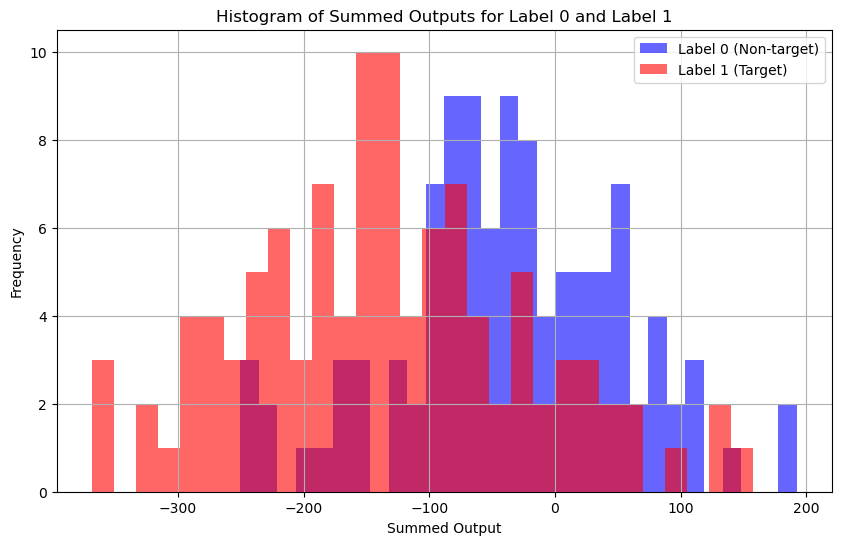

In [13]:
import matplotlib.pyplot as plt

# Separate summed outputs by label
summed_outputs_0 = all_summed_outputs[all_labels == 0]
summed_outputs_1 = all_summed_outputs[all_labels == 1]

# Plot histograms of summed outputs for both classes
plt.figure(figsize=(10, 6))
plt.hist(summed_outputs_0, bins=30, alpha=0.6, label='Label 0 (Non-target)', color='blue')
plt.hist(summed_outputs_1, bins=30, alpha=0.6, label='Label 1 (Target)', color='red')
plt.xlabel('Summed Output')
plt.ylabel('Frequency')
plt.title('Histogram of Summed Outputs for Label 0 and Label 1')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


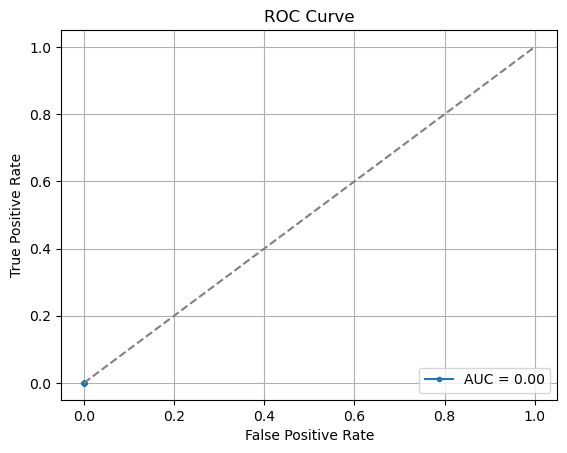

AUC: 0.00


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc

threshold_vals = np.arange(0., 100., 5.0)

# Function to plot the ROC curve and calculate AUC 
def plot_roc_curve(model, test_loader, threshold_vals):
    TPRs = [] 
    FPRs = []  

    model.output = 'spike'

    for th in threshold_vals:
        model.seq[-1].threshold = torch.tensor(th, dtype=torch.float32).to(device)
        
        true_positive = 0
        false_positive = 0
        true_negative = 0
        false_negative = 0

        for inputs, labels in test_loader:
            inputs = inputs.permute(0, 2, 1).to(device)
            labels = labels.to(device)

            outputs, _, _ = model(inputs, record=True)
            outputs_sum = outputs.sum(dim=1).detach().cpu().numpy()  

            # Binary prediction based on summed spiking activity
            predictions = (outputs_sum > 0).astype(int)
            
            true_positive += ((predictions == 1) & (labels.cpu().numpy() == 1)).sum()
            false_positive += ((predictions == 1) & (labels.cpu().numpy() == 0)).sum()
            true_negative += ((predictions == 0) & (labels.cpu().numpy() == 0)).sum()
            false_negative += ((predictions == 0) & (labels.cpu().numpy() == 1)).sum()

        # Calculate TPR and FPR for the current threshold
        TPR = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0.0
        FPR = false_positive / (false_positive + true_negative) if (false_positive + true_negative) > 0 else 0.0
        
        TPRs.append(TPR)
        FPRs.append(FPR)

    auc_value = auc(FPRs, TPRs)

    # Plot ROC Curve
    plt.figure()
    plt.plot(FPRs, TPRs, marker='.', label=f'AUC = {auc_value:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    return TPRs, FPRs, auc_value

# Compute and plot the ROC curve
TPRs, FPRs, auc_value = plot_roc_curve(model, test_loader, threshold_vals)
print(f"AUC: {auc_value:.2f}")

In [15]:
# Use a batch from the test_loader as the input for debugging
for inputs, labels in test_loader:
    inputs = inputs.permute(0, 2, 1).to(device)  # Ensure correct input shape for the model
    print(f"Input batch shape: {inputs.shape}")

    # Iterate through each layer of the model
    for name, layer in model.seq.named_children():
        print(f"Passing through layer: {name}")
        try:
            # Pass the inputs through the current layer
            outputs = layer(inputs)
            
            # If the output is a tuple, extract the first element (assumed to be the main tensor)
            if isinstance(outputs, tuple):
                inputs = outputs[0]  # Select the tensor part of the output
                print(f"Output of {name} is a tuple, taking the first element.")
            else:
                inputs = outputs  # Directly use the output if it is a tensor
            
            # Check if the output contains NaNs
            if torch.isnan(inputs).any():
                print(f"NaN detected after layer {name}")
                break  # Stop further checks if NaNs are detected

        except Exception as e:
            print(f"Error in layer {name}: {e}")
            break
    
    # Break after the first batch for initial analysis
    break


Input batch shape: torch.Size([32, 101, 16])
Passing through layer: 0_LinearTorch
Output of 0_LinearTorch is a tuple, taking the first element.
Passing through layer: 1_LIFTorch
Output of 1_LIFTorch is a tuple, taking the first element.
Passing through layer: 2_TimeStepDropout
Output of 2_TimeStepDropout is a tuple, taking the first element.
Passing through layer: 3_LinearTorch
Output of 3_LinearTorch is a tuple, taking the first element.
Passing through layer: 4_LIFTorch
Output of 4_LIFTorch is a tuple, taking the first element.
Passing through layer: 5_TimeStepDropout
Output of 5_TimeStepDropout is a tuple, taking the first element.
Passing through layer: 6_LinearTorch
Output of 6_LinearTorch is a tuple, taking the first element.
Passing through layer: 7_LIFTorch
Output of 7_LIFTorch is a tuple, taking the first element.
Passing through layer: 8_TimeStepDropout
Output of 8_TimeStepDropout is a tuple, taking the first element.
Passing through layer: 9_LinearTorch
Output of 9_LinearTor